# ImageNet Read and Export Results

To get the data, please visit `Download.md` in `data/` folder

In [1]:
import pandas as pd
import glob
import pickle
import numpy as np

from datetime import datetime
import seaborn as sns
sns.set()

import copy
import json
from torchvision.datasets import ImageFolder

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
# Build the ground truth dictionary 

# Map method # -> Method name
mapping = {'No-XAI':1 , 'KNNs': 2, 'EMD-NNs': 3, 'EMD-Corrs': 3, 'CHM-NNs': 4, 'CHM-Corrs': 4}
exp = 'ImageNet'

DEBUG = False
if DEBUG:
    exp = 'ImageNet'

ground_truth = dict()
if exp == 'ImageNet':
    Task1_images_dict = np.load('../../data/raw_data/Task1_metadata.npy', allow_pickle='False').item()
else: # CUB200
    raise Exception("Not yet implemented!")

for method in mapping.keys():
    ground_truth[method] = {}
    for correctness in ['Correct', 'Wrong']:
        if correctness == 'Correct':
            answer = 'Yes'
        else:
            answer = 'No'
        for img_name in Task1_images_dict['Method{}'.format(mapping[method])][correctness].keys():
            ground_truth[method][img_name] = answer
            


In [4]:
DEBUG=True

In [5]:
# 1. Read the information from csv files to dictionary. Each user ID is an entry

import pandas as pd  
import os
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Check if a number is float?
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Task aliases assigned by Gorilla
exp_hierarchy = ['randomiser-tjl7', {'No-XAI':'counterbalance-lxdj' , 'KNNs': 'counterbalance-yqqs', 
                                     'EMD-NNs': 'counterbalance-jiws', 'EMD-Corrs': 'counterbalance-eqty', 
                                     'CHM-NNs': 'counterbalance-xsf1', 'CHM-Corrs': 'counterbalance-4ym2'}]

methods = mapping.keys()

# Loop all csv file, each csv file is an explanation method
files = []

list_1 = glob.glob('../../data/raw_data/ImageNet/1/*.csv')
list_0 = glob.glob('../../data/raw_data/ImageNet/2/*.csv')

for file in list_1+list_0:
    if '.csv' in file:
        files.append(file)
        

# Validation threshold to classify good/bad users
if exp == 'ImageNet':
    threshold = 1
else: # CUB200
    threshold = 1

# Store information of bad users to a dict
# csv_file = open('~/src/experiment_data/{}_bad_users.csv'.format(exp), 'w')

final_result = dict()
trial_cnt = dict()

# Initialize the dictionary for users' responses (answer)
final_result[exp] = dict()
trial_cnt[exp] = dict()
for method in methods:
    final_result[exp][method] = dict()
    trial_cnt[exp][method] = dict()

# Correct answer dictionary in validation 
val_correct_dict = dict()
# Incorrect answer dictionary in validation 
val_incorrect_trials_dict = dict()

test_correct_trials_dict = dict()
test_incorrect_trials_dict = dict()

# Numbers of users for methods
user_cnt_dict = dict()

# Reaction time dictionary 
users_avg_reaction_time_dict = dict()
users_stdev_reaction_time_dict = dict()
below_stdev_reaction_time_dict = dict()

# Counter-balances for methods
counter_balances_dict = dict()

# Numbers of good users for methods
good_user_cnt_dict = dict()
good_user_cnt = 0
bad_user_cnt = 0
users_reaction_times = []
user_dict = dict()


for file in files:

    # We skip the Questionnaire Node
    if 'questionnaire-9g37' in file:
        continue
    
    # We skip the Complete and Reject Node
    if '7pqn' in file or '77vw' in file:
        continue
    
    reaction_time_correct_cnt_dict = dict()
    users_reaction_time = []
    users_val_incorrect_trials = []
    counter_balances = []
    user_cnt = 0
    trail_date_tile = []
    df = pd.read_csv(file)
    # 
    for index, row in df.iterrows():
        # Start the spreadsheet for a user
        if row['Event Index'] != 'END OF FILE' and int(row['Event Index']) == 1:
            trail_date_tile
            user_cnt += 1
            reaction_time = 0
            reaction_times = []

            val_correct = 0
            val_incorrect = 0
            val_incorrect_trials = []
            val_trial_cnt = 0
            
            test_reaction_time = 0
            val_reaction_time = 0

            test_trial_answers = {}

            task_name = row['Task Name']
            
            task = exp
            
            # Extract the method name. E.g, KNNs
            
            method = row['randomiser-tjl7']
            counter_balance = int(row[exp_hierarchy[1][method]])
            if DEBUG:
                public_id = int(row['Participant Private ID'])
            else:
                public_id = row['Participant Public ID']
            
            if task not in user_dict:
                user_dict[task] = dict()
                    
            if method not in user_dict[task]:
                user_dict[task][method] = dict()
            if public_id not in user_dict[task][method]:
                user_dict[task][method][public_id] = dict()
                user_dict[task][method][public_id]['Trials'] = dict()
                user_dict[task][method][public_id]['Prior Knowledge'] = dict()
                user_dict[task][method][public_id]['Counter balance'] = counter_balance
                user_dict[task][method][public_id]['Known'] = 0
                user_dict[task][method][public_id]['Unknown'] = 0
        
        trial_time = row['Reaction Time']
            
        # Check users' responses in validation -- Screen 3 is where users make decision -- 
        # TODO: re-check this as we re-layout the test UI (maybe the screen 3 is not where users make decision)
        if row['display'] == 'Validation' and row['Screen Name'] == 'Screen 3':
            val_trial_cnt += 1
            if row['Correct'] == 1:
                val_correct += 1
            elif row['Incorrect'] == 1:
                val_incorrect += 1
                val_incorrect_trials.append(val_trial_cnt)
            else:
                raise ValueError("Wrong value!")
                
            user_dict[task][method][public_id]['Validation Correct'] = val_correct
            user_dict[task][method][public_id]['Validation Incorrect'] = val_incorrect
            user_dict[task][method][public_id]['Incorrect Validation Trials'] = val_incorrect_trials
            
        elif row['display'] == 'Trial' and row['Screen Name'] == 'Screen 1':
            prior_knowledge = row['Response']
                
        # Check users' responses in test
        elif row['display'] == 'Trial' and row['Screen Name'] == 'Screen 3':
            file_name = row['file_name' + str(counter_balance)]
            test_trial_answers[file_name] = row['Response']
            
            user_dict[task][method][public_id]['Trials'][file_name] = row['Response']
            user_dict[task][method][public_id]['Prior Knowledge'][file_name] = prior_knowledge
        
        # Time from instructions -> the end of Validation
        if row['display'] != 'Trial':
            if (isinstance(row['Reaction Time'], str) and is_float(row['Reaction Time'])) or (isinstance(row['Reaction Time'], float) and not math.isnan(row['Reaction Time'])):
                val_reaction_time += float(row['Reaction Time'])
        
        # End the spreadsheet for a user
        if row['Trial Number'] == 'END TASK':
            reaction_time = float(row['Reaction Time'])
            
            # Validation and Test are combined
            user_dict[task][method][public_id]['Validation Reaction Time'] = val_reaction_time
            user_dict[task][method][public_id]['Test Reaction Time'] = reaction_time - test_reaction_time
            
            dt_object = datetime.fromtimestamp(row['UTC Timestamp']/1000)
            user_dict[task][method][public_id]['DATE'] = dt_object


/tmp/ipykernel_2344027/1598973943.py:99: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2344027/1598973943.py:99: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2344027/1598973943.py:99: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2344027/1598973943.py:99: DtypeWarning: Columns (0,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2344027/1598973943.py:99: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2344027/1598973943.py:99: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f

In [6]:
# 2. Process the dictionary to extract findings

performance_data = {}
performance_data_mean = {}
performance_data_std   = {}

test_correct_trials_dict = dict()

# Initialize the dictionary for users' responses (answer)

final_result[exp] = dict()
trial_cnt[exp] = dict()
for method in methods:
    final_result[exp][method] = dict()
    trial_cnt[exp][method] = dict()


perf_stats_dict = dict()

for method in methods:
    if method not in user_dict[task]:
        continue
            
    good_user_cnt = 0
    hacking_user_cnt = 0
    correct_cnt_list = []
    natural_correct_cnt_list = []
    adversarial_correct_cnt_list = []
    
    if task == 'ImageNet':
        task_list = ['ImageNet']
    elif task == 'CUB200':
        task_list = ['CUB200']
    
    if method not in test_correct_trials_dict:
        test_correct_trials_dict[method] = dict()
    
    # Loop over all users within each method and determine if this is a good/bad users?
    for user_id in user_dict[task][method].keys():
            
        user_dict[task][method][user_id]['Known'] = 0
        user_dict[task][method][user_id]['Unknown'] = 0
    
        good_user_cnt += 1
        trials = user_dict[task][method][user_id]['Trials']
        
        # Initialize: The correct times a trial gets {trial_name: times}
        for trial_key in trials.keys():
            if trial_key not in test_correct_trials_dict[method]:
                test_correct_trials_dict[method][trial_key] = dict()
                test_correct_trials_dict[method][trial_key]['Count'] = 0
                test_correct_trials_dict[method][trial_key]['Counter balance'] = list()
            test_correct_trials_dict[method][trial_key]['Counter balance'].append(user_dict[task][method][user_id]['Counter balance'])
        
        # Record the number of correct answers of a user
        for sub_task in task_list: 
            user_dict[task][method][user_id][sub_task] = dict()
            exp_gt = ground_truth[method]

            shared_items = {k: exp_gt[k] for k in exp_gt if k in trials and exp_gt[k] == trials[k]}
            user_dict[task][method][user_id][sub_task] = len(shared_items)

            # Get: The correct times a trial gets {trial_name: times}
            for key in shared_items.keys():
                test_correct_trials_dict[method][key]['Count'] += 1
                test_correct_trials_dict[method][key]['Task'] = sub_task
                if user_dict[task][method][user_id]['Prior Knowledge'][key] == 'Yes':
                    user_dict[task][method][user_id]['Known'] += 1
                else:
                    user_dict[task][method][user_id]['Unknown'] += 1

        correct_cnt = user_dict[exp][method][user_id][exp]
        # print(user_dict[exp][method][user_id][exp])
        correct_cnt_list.append((correct_cnt/30)*100)
    
    print(f'Method = {method} Mean Accuracy = {statistics.mean(correct_cnt_list):.3f} on {good_user_cnt} Users')
    
    performance_data[method] = np.asarray(correct_cnt_list)
    performance_data_mean[method] = statistics.mean(correct_cnt_list)
    performance_data_std[method]   = statistics.stdev(correct_cnt_list)
    
    print('Method = {}\nstd_dev = {}'.format(method, statistics.stdev(correct_cnt_list)))
    print(f"Mean = {statistics.mean(correct_cnt_list):.3f}")

Method = No-XAI Mean Accuracy = 81.556 on 60 Users
Method = No-XAI
std_dev = 5.539336022087802
Mean = 81.556
Method = KNNs Mean Accuracy = 75.444 on 60 Users
Method = KNNs
std_dev = 8.829130578211318
Mean = 75.444
Method = EMD-NNs Mean Accuracy = 76.722 on 60 Users
Method = EMD-NNs
std_dev = 9.297179100896651
Mean = 76.722
Method = EMD-Corrs Mean Accuracy = 78.389 on 60 Users
Method = EMD-Corrs
std_dev = 7.50371324693003
Mean = 78.389
Method = CHM-NNs Mean Accuracy = 77.556 on 60 Users
Method = CHM-NNs
std_dev = 6.912601192147743
Mean = 77.556
Method = CHM-Corrs Mean Accuracy = 76.722 on 60 Users
Method = CHM-Corrs
std_dev = 8.470435272016799
Mean = 76.722


# Create Dataframe (ALL DATA)

In [7]:
Method_name_map = {'No-XAI': 'Method1', 'KNNs': 'Method2', 'EMD-NNs':'Method3', 'EMD-Corrs':'Method3', 'CHM-Corrs':'Method4', 'CHM-NNs':'Method4'}

In [8]:
Task1_images_dict.keys()

dict_keys(['Method1', 'Method2', 'Method3', 'Method4'])

In [9]:
GT = {}

for k in user_dict['ImageNet'].keys():
  GT[k] = {}
  
  Corrects = Task1_images_dict[Method_name_map[k]]['Correct']
  Wrongs  = Task1_images_dict[Method_name_map[k]]['Wrong']

  for c in Corrects:
    GT[k][c] = 1
  for c in Wrongs:
    GT[k][c] = 0

In [10]:
def check_performance(user_inputs, gt):
  correctness = []
  for k, v in user_inputs.items():
    if gt[k]== 1 and v == 'Yes':
      correctness.append(1)
    elif gt[k]== 0 and v == 'No':
      correctness.append(1)
    else:
      correctness.append(0)

  return np.asarray(correctness)

In [11]:
user_information = {}

for k in user_dict['ImageNet'].keys():
  for u in user_dict['ImageNet'][k].keys():
    user_information[u] = user_dict['ImageNet'][k][u]
    user_information[u]['Correctness'] = check_performance(user_information[u]['Trials'], GT[k])
    user_information[u]['Accuracy'] = np.mean(user_information[u]['Correctness']) 
    user_information[u]['Corrects'] = np.count_nonzero(user_information[u]['Correctness'] == 1) 
    user_information[u]['Method'] = k

### Manually Remove Bad Users

In [12]:
df = pd.DataFrame.from_dict(user_information).T

df['Validation Reaction Time'] = (df['Validation Reaction Time']/1000.0).astype(float)
df['Test Reaction Time']       = (df['Test Reaction Time']/1000.0).astype(float)
df['Accuracy'] = df['Accuracy'].astype(float)
df['Accuracy'] = df['Accuracy'].astype(float)

In [13]:
df.head()

,Trials,Prior Knowledge,Counter balance,Known,Unknown,Validation Reaction Time,Test Reaction Time,DATE,Validation Correct,Validation Incorrect,Incorrect Validation Trials,ImageNet,Correctness,Accuracy,Corrects,Method
6386009,"{'ILSVRC2012_val_00027121.JPEG': 'Yes', 'ILSVR...","{'ILSVRC2012_val_00027121.JPEG': 'No', 'ILSVRC...",15,15,7,677.6827,340.827,2022-05-01 00:17:34.793,10,0,[],22,"[1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",0.733333,22,CHM-NNs
6386055,"{'ILSVRC2012_val_00001717.JPEG': 'No', 'ILSVRC...","{'ILSVRC2012_val_00001717.JPEG': 'No', 'ILSVRC...",11,18,5,377.5681,191.191,2022-05-01 00:23:23.449,9,1,[2],23,"[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.766667,23,CHM-NNs
6386067,"{'ILSVRC2012_val_00043746.JPEG': 'Yes', 'ILSVR...","{'ILSVRC2012_val_00043746.JPEG': 'Yes', 'ILSVR...",10,26,1,188.8774,94.889,2022-05-01 00:23:25.214,10,0,[],27,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, ...",0.900000,27,CHM-NNs
6386064,"{'ILSVRC2012_val_00048061.JPEG': 'Yes', 'ILSVR...","{'ILSVRC2012_val_00048061.JPEG': 'Yes', 'ILSVR...",14,17,9,271.0685,136.416,2022-05-01 00:23:45.054,10,0,[],26,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.866667,26,CHM-NNs
6386065,"{'ILSVRC2012_val_00005684.JPEG': 'Yes', 'ILSVR...","{'ILSVRC2012_val_00005684.JPEG': 'No', 'ILSVRC...",8,18,5,548.8668,275.580,2022-05-01 00:26:28.303,10,0,[],23,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, ...",0.766667,23,CHM-NNs


### Counter Balance Ratio

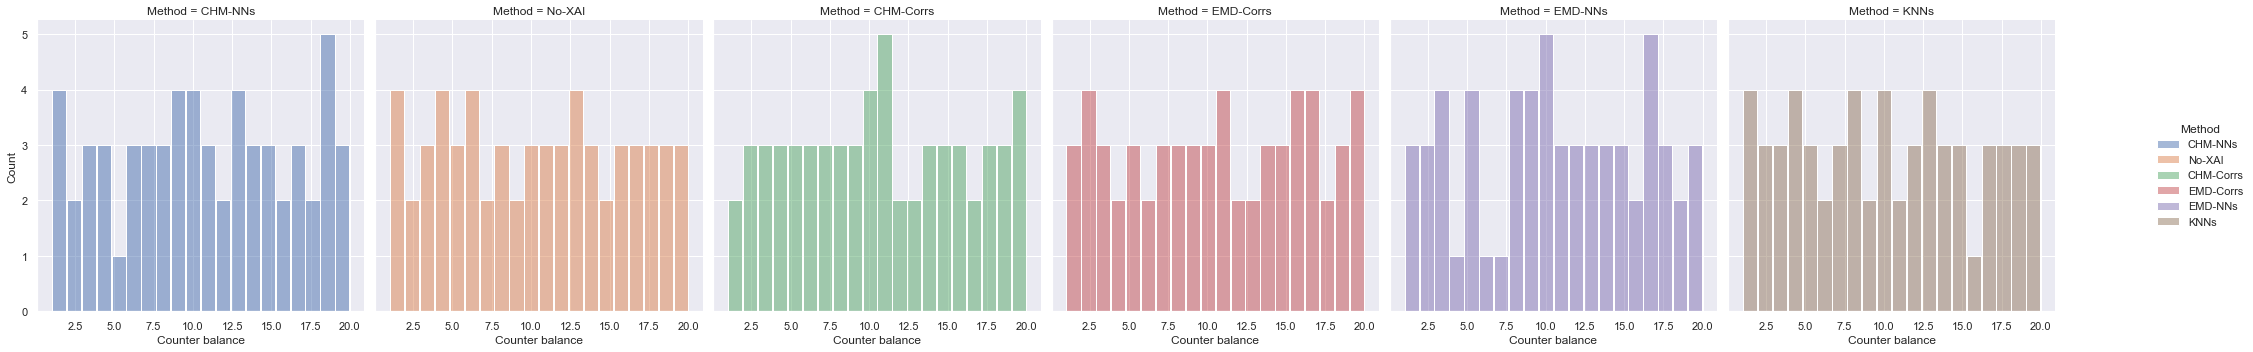

In [14]:
sns.displot(
    df, x="Counter balance", col="Method", bins=20 ,kde=False, common_bins=False,
    height=5, facet_kws=dict(margin_titles=True), hue="Method", shrink=.95
)

plt.show()

In [15]:
df.groupby('Method').mean()['Accuracy'].reset_index().sort_values(by='Method', ascending=False)

,Method,Accuracy
5,No-XAI,0.815556
4,KNNs,0.754444
3,EMD-NNs,0.767222
2,EMD-Corrs,0.783889
1,CHM-NNs,0.775556
0,CHM-Corrs,0.767222


# Second Dataframe

##  Add Parent Category for auto-level

In [16]:
# TODO: Each Row show be a user response with user id, image name, user response, image label, image category, Selected method

In [17]:
Method_name_map = {'No-XAI': 'Method1', 'KNNs': 'Method2', 'EMD-NNs':'Method3', 'EMD-Corrs':'Method3', 'CHM-Corrs':'Method4', 'CHM-NNs':'Method4'}

In [18]:
with open('../../data/raw_data/imagenet-labels.json', 'r')as f:
  labels = json.load(f)

In [19]:
parent_df12 = pd.read_csv('../../data/raw_data/ImageNet-Method-1-4-AutoLevel12.csv')
parent_df13 = pd.read_csv('../../data/raw_data/ImageNet-Method-1-4-AutoLevel13.csv')
parent_df14 = pd.read_csv('../../data/raw_data/ImageNet-Method-1-4-AutoLevel14.csv')

In [20]:
# IMAGENET VALIDATION FOLDER
valfolder = ImageFolder('/home/mohammad/dataset/ILSVRC2012_img_val/')

ids_to_wnids = {x[1]:x[0].split('/')[-2] for x in valfolder.imgs}
GT_WNIDS = {os.path.basename(x[0]):x[0].split('/')[-2] for x in valfolder.imgs}

PARENT12_WNID = {j['GT']:j['Parent'].split('.')[0] for i,j in parent_df12[['GT', 'Parent']].iterrows()}
PARENT13_WNID = {j['GT']:j['Parent'].split('.')[0] for i,j in parent_df13[['GT', 'Parent']].iterrows()}
PARENT14_WNID = {j['GT']:j['Parent'].split('.')[0] for i,j in parent_df14[['GT', 'Parent']].iterrows()}

In [21]:
GT = {}

for k in user_dict['ImageNet'].keys():
  GT[k] = {}
  
  Corrects = Task1_images_dict[Method_name_map[k]]['Correct']
  Wrongs  = Task1_images_dict[Method_name_map[k]]['Wrong']

  for c in Corrects:
    GT[k][c] = 1
  for c in Wrongs:
    GT[k][c] = 0

In [22]:
def check_performance(user_inputs, gt):
  correctness = []
  for k, v in user_inputs.items():
    if gt[k]== 1 and v == 'Yes':
      correctness.append(1)
    elif gt[k]== 0 and v == 'No':
      correctness.append(1)
    else:
      correctness.append(0)

  return np.asarray(correctness)

In [23]:
user_information = {}

for k in user_dict['ImageNet'].keys():
  for u in user_dict['ImageNet'][k].keys():
    
    user_information[u] = copy.deepcopy(user_dict['ImageNet'][k][u])
    
    user_information[u]['Prior Knowledge'] =   user_dict['ImageNet'][k][u]['Prior Knowledge'].values()
    
    user_information[u]['Correctness'] = check_performance(user_information[u]['Trials'], GT[k])
    user_information[u]['Accuracy'] = np.mean(user_information[u]['Correctness']) 
    user_information[u]['Corrects'] = np.count_nonzero(user_information[u]['Correctness'] == 1) 
    user_information[u]['Method'] = k

In [24]:
df = pd.DataFrame.from_dict(user_information).T

In [25]:
df2 = df.explode(['Trials', 'Prior Knowledge', 'Correctness']).reset_index(drop=False).drop(['Incorrect Validation Trials'], 1)

df2['Prior Knowledge'] = [1 if v=='Yes' else 0 for v in df2['Prior Knowledge']]

/tmp/ipykernel_2344027/3088959643.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df.explode(['Trials', 'Prior Knowledge', 'Correctness']).reset_index(drop=False).drop(['Incorrect Validation Trials'], 1)


In [26]:
df2.head()

,index,Trials,Prior Knowledge,Counter balance,Known,Unknown,Validation Reaction Time,Test Reaction Time,DATE,Validation Correct,Validation Incorrect,ImageNet,Correctness,Accuracy,Corrects,Method
0,6386009,ILSVRC2012_val_00027121.JPEG,0,15,15,7,677682.700001,340827.0,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs
1,6386009,ILSVRC2012_val_00008987.JPEG,0,15,15,7,677682.700001,340827.0,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs
2,6386009,ILSVRC2012_val_00043672.JPEG,1,15,15,7,677682.700001,340827.0,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NNs
3,6386009,ILSVRC2012_val_00011479.JPEG,1,15,15,7,677682.700001,340827.0,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs
4,6386009,ILSVRC2012_val_00034787.JPEG,1,15,15,7,677682.700001,340827.0,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NNs


In [27]:
df2.columns

Index(['index', 'Trials', 'Prior Knowledge', 'Counter balance', 'Known',
       'Unknown', 'Validation Reaction Time', 'Test Reaction Time', 'DATE',
       'Validation Correct', 'Validation Incorrect', 'ImageNet', 'Correctness',
       'Accuracy', 'Corrects', 'Method'],
      dtype='object')

In [28]:
df2 = df.explode(['Trials', 'Prior Knowledge', 'Correctness']).reset_index(drop=False).drop(['Incorrect Validation Trials'], 1)

df2['Prior Knowledge'] = [1 if v=='Yes' else 0 for v in df2['Prior Knowledge']]

df2.columns = ['UID', 'Query', 'Prior Knowledge', 'Counter balance', 'Group Known', 'Group Unknown', 'Validation Reaction Time', 'Test Reaction Time', 'DATE',
        'Group Validation Correct', 'Group Validation Incorrect', 'ImageNet', 'Correctness', 'User Accuracy', 'User Corrects', 'Method']


wnids = [GT_WNIDS[x] for x in  df2.Query]

parents12 = [PARENT12_WNID[x] for x in  wnids]
parents13 = [PARENT13_WNID[x] for x in  wnids]
parents14 = [PARENT14_WNID[x] for x in  wnids]


df2['GroundTruth'] = wnids
df2['Parent-lvl12'] = parents12
df2['Parent-lvl13'] = parents13
df2['Parent-lvl14'] = parents14

df2 = df2.convert_dtypes()

/tmp/ipykernel_2344027/4077716112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df.explode(['Trials', 'Prior Knowledge', 'Correctness']).reset_index(drop=False).drop(['Incorrect Validation Trials'], 1)


In [29]:
df2.head()

,UID,Query,Prior Knowledge,Counter balance,Group Known,Group Unknown,Validation Reaction Time,Test Reaction Time,DATE,Group Validation Correct,Group Validation Incorrect,ImageNet,Correctness,User Accuracy,User Corrects,Method,GroundTruth,Parent-lvl12,Parent-lvl13,Parent-lvl14
0,6386009,ILSVRC2012_val_00027121.JPEG,0,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs,n02112350,carnivore,canine,dog
1,6386009,ILSVRC2012_val_00008987.JPEG,0,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs,n01980166,invertebrate,invertebrate,invertebrate
2,6386009,ILSVRC2012_val_00043672.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NNs,n02093428,carnivore,canine,dog
3,6386009,ILSVRC2012_val_00011479.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs,n04350905,commodity,commodity,commodity
4,6386009,ILSVRC2012_val_00034787.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NNs,n07754684,natural_object,natural_object,natural_object


## Classifier Correctness

In [30]:
ClassifierCorrectness = []

for i, MQ in df2[['Method', 'Query']].iterrows():
  corrects = Task1_images_dict[Method_name_map[MQ['Method']]]['Correct'].keys()
  wrongs   = Task1_images_dict[Method_name_map[MQ['Method']]]['Wrong'].keys()
  
  if MQ['Query'] in corrects:
    ClassifierCorrectness.append(1)
  elif MQ['Query'] in wrongs:   
    ClassifierCorrectness.append(0)
  else:
    raise


In [31]:
df2['ClassifierCorrectness'] = ClassifierCorrectness

## AI Confidence and Easy Medium Hard Samples

In [32]:
with open('../../data/raw_data/ImageNet50K.pickle', 'rb') as f:
  ImageNet = pickle.load(f)
  
with open('../../data/raw_data/imagenet1k-val-50k-emd_results_floral-totem-288.pickle', 'rb') as f:
  Method3_All = pickle.load(f)

In [33]:
with open('../../data/raw_data/ImageNet1K-50K-Method1.pickle', 'rb')as f:
  Method1_ALL = pickle.load(f)

In [34]:
REAL_GTs = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['gt_real_labels'] for x in range(len(ImageNet))}
# CONFIDENCE SCORES
KNN_CONF = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['knn-prediction-confidance'] for x in range(len(ImageNet))}
CHM_CONF = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['chm-prediction-confidance'] for x in range(len(ImageNet))}
EMD_CONF = {os.path.basename(Method3_All['prediction_info'][x]['query-path']):Method3_All['prediction_info'][x]['emd-confidence'] for x in range(50_000)}

In [35]:
KNN_Preds = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['knn-prediction'] for x in range(len(ImageNet))}
EMD_Preds = {os.path.basename(Method3_All['prediction_info'][x]['query-path']):Method3_All['prediction_info'][x]['emd-predictions'] for x in range(50_000)}
CHM_Preds = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['chm-prediction'] for x in range(len(ImageNet))}

In [36]:
def get_conf(q, method):
  if method=='No-XAI':
    if q in Task1_images_dict[Method_name_map[method]]['Correct'].keys():
      return Task1_images_dict[Method_name_map[method]]['Correct'][q]['ResNet50-confidence']/100
    if q in Task1_images_dict[Method_name_map[method]]['Wrong'].keys():
      return Task1_images_dict[Method_name_map[method]]['Wrong'][q]['ResNet50-confidence']/100
  
  elif method=='KNNs':
    if q in Task1_images_dict[Method_name_map[method]]['Correct'].keys():
      return Task1_images_dict[Method_name_map[method]]['Correct'][q]['confidence']/20
    if q in Task1_images_dict[Method_name_map[method]]['Wrong'].keys():
      return Task1_images_dict[Method_name_map[method]]['Wrong'][q]['confidence']/20

  elif method=='EMD-NNs':
    if q in Task1_images_dict[Method_name_map[method]]['Correct'].keys():
      return EMD_CONF[q]/20
    if q in Task1_images_dict[Method_name_map[method]]['Wrong'].keys():
      return EMD_CONF[q]/20
  
  elif method=='EMD-Corrs':
    if q in Task1_images_dict[Method_name_map[method]]['Correct'].keys():
      return EMD_CONF[q]/20
    if q in Task1_images_dict[Method_name_map[method]]['Wrong'].keys():
      return EMD_CONF[q]/20
  
  elif method=='CHM-NNs':
    if q in Task1_images_dict[Method_name_map[method]]['Correct'].keys():
      return CHM_CONF[q]/20
    if q in Task1_images_dict[Method_name_map[method]]['Wrong'].keys():
      return CHM_CONF[q]/20
  
  elif method=='CHM-Corrs':
    if q in Task1_images_dict[Method_name_map[method]]['Correct'].keys():
      return CHM_CONF[q]/20
    if q in Task1_images_dict[Method_name_map[method]]['Wrong'].keys():
      return CHM_CONF[q]/20
  else:
    raise

In [37]:
DifficultyLevel = []

for i, MQ in df2[['Method', 'Query']].iterrows():
  corrects = Task1_images_dict[Method_name_map[MQ['Method']]]['Correct'].keys()
  wrongs   = Task1_images_dict[Method_name_map[MQ['Method']]]['Wrong'].keys()
  conf = get_conf(MQ['Query'], MQ['Method'])
  
  if MQ['Query'] in corrects:
    
    if conf>=0 and conf <0.35:
      DifficultyLevel.append('Hard')
    elif conf>=0.35 and conf <0.75:
      DifficultyLevel.append('Medium')
    elif conf>=0.75 and conf <=1:
      DifficultyLevel.append('Easy')
    else:
      DifficultyLevel.append('UnCat')
    
  elif MQ['Query'] in wrongs:   
    
    if conf>=0 and conf <0.35:
      DifficultyLevel.append('Easy')
    elif conf>=0.35 and conf <0.75:
      DifficultyLevel.append('Medium')
    elif conf>=0.75 and conf <=1:
      DifficultyLevel.append('Hard')
    else:
      DifficultyLevel.append('UnCat')
    
  else:
    raise

In [38]:
ConfidenceScore = []

for i, MQ in df2[['Method', 'Query']].iterrows():
  corrects = Task1_images_dict[Method_name_map[MQ['Method']]]['Correct'].keys()
  wrongs   = Task1_images_dict[Method_name_map[MQ['Method']]]['Wrong'].keys()
  conf = get_conf(MQ['Query'], MQ['Method'])
  ConfidenceScore.append(conf)

In [39]:
df2['DifficultyLevel'] = DifficultyLevel
df2['ConfidenceScore'] = ConfidenceScore

In [40]:
from collections import Counter

In [41]:
Counter(df2['ClassifierCorrectness'])

Counter({1: 5444, 0: 5356})

In [42]:
df2.groupby(['Method', 'ClassifierCorrectness'])['ClassifierCorrectness'].count()

Method     ClassifierCorrectness
CHM-Corrs  0                        897
           1                        903
CHM-NNs    0                        889
           1                        911
EMD-Corrs  0                        895
           1                        905
EMD-NNs    0                        887
           1                        913
KNNs       0                        882
           1                        918
No-XAI     0                        906
           1                        894
Name: ClassifierCorrectness, dtype: int64

# Add GT and All Method's prediction

In [43]:
REAL_GTs = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['gt_real_labels'] for x in range(len(ImageNet))}
REAL_GTs_WNIDs = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['gt_real_wnids'] for x in range(len(ImageNet))}

# CONFIDENCE SCORES
KNN_CONF = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['knn-prediction-confidance'] for x in range(len(ImageNet))}
CHM_CONF = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['chm-prediction-confidance'] for x in range(len(ImageNet))}

EMD_CONF = {os.path.basename(Method3_All['prediction_info'][x]['query-path']):Method3_All['prediction_info'][x]['emd-confidence'] for x in range(50_000)}

In [44]:
KNN_Preds = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['knn-prediction'] for x in range(len(ImageNet))}
EMD_Preds = {os.path.basename(Method3_All['prediction_info'][x]['query-path']):labels[Method3_All['prediction_info'][x]['emd-predictions']] for x in range(50_000)}
CHM_Preds = {os.path.basename(ImageNet[x]['q']):  ImageNet[x]['chm-prediction'] for x in range(len(ImageNet))}

In [45]:
RESNET_Preds = {os.path.basename(ImageNet[x]['q']):  labels[ids_to_wnids[Method1_ALL[0][x]]] for x in range(len(ImageNet))} 
RESNET_CONF = {os.path.basename(ImageNet[x]['q']):  Method1_ALL[1][x]/100  for x in range(len(ImageNet))}   #{Method1_ALL[1][x]}

In [46]:
methd_1_prediction = [RESNET_Preds[x] for x in df2['Query']]
methd_2_prediction = [KNN_Preds[x] for x in df2['Query']]
methd_3_prediction = [EMD_Preds[x] for x in df2['Query']]
methd_4_prediction = [CHM_Preds[x] for x in df2['Query']]

methd_1_conf = [RESNET_CONF[x] for x in df2['Query']]
methd_2_conf = [KNN_CONF[x]/20.0 for x in df2['Query']]
methd_3_conf = [EMD_CONF[x]/20.0 for x in df2['Query']]
methd_4_conf = [CHM_CONF[x]/20.0 for x in df2['Query']]

gt_real_column = [REAL_GTs[x] for x in df2['Query']]
gt_real_column_wnid = [REAL_GTs_WNIDs[x] for x in df2['Query']]

In [47]:
df2['ResNet-Prediction']= methd_1_prediction 
df2['KNN-Prediction']   = methd_2_prediction 
df2['EMD-Prediction']   = methd_3_prediction 
df2['CHM-Prediction']   = methd_4_prediction 

In [48]:
df2['ResNet-Conf']= methd_1_conf
df2['KNN-Conf']   = methd_2_conf
df2['EMD-Conf']   = methd_3_conf
df2['CHM-Conf']   = methd_4_conf

In [49]:
df2['Real GTs'] = gt_real_column

df2['Real WNIDs'] = gt_real_column_wnid

In [50]:
real_wnids = [REAL_GTs_WNIDs[x] for x in  df2.Query]
parents12_real = [[PARENT12_WNID[x] for x in y] for y in  real_wnids]
parents13_real = [[PARENT13_WNID[x] for x in y] for y in  real_wnids]
parents14_real = [[PARENT14_WNID[x] for x in y] for y in  real_wnids]

In [51]:
df2['Parent-lvl12_real'] = parents12_real
df2['Parent-lvl13_real'] = parents13_real
df2['Parent-lvl14_real'] = parents14_real

In [52]:
df2.head(5)

,UID,Query,Prior Knowledge,Counter balance,Group Known,Group Unknown,Validation Reaction Time,Test Reaction Time,DATE,Group Validation Correct,Group Validation Incorrect,ImageNet,Correctness,User Accuracy,User Corrects,Method,GroundTruth,Parent-lvl12,Parent-lvl13,Parent-lvl14,ClassifierCorrectness,DifficultyLevel,ConfidenceScore,ResNet-Prediction,KNN-Prediction,EMD-Prediction,CHM-Prediction,ResNet-Conf,KNN-Conf,EMD-Conf,CHM-Conf,Real GTs,Real WNIDs,Parent-lvl12_real,Parent-lvl13_real,Parent-lvl14_real
0,6386009,ILSVRC2012_val_00027121.JPEG,0,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs,n02112350,carnivore,canine,dog,1,Easy,1.0,keeshond,keeshond,keeshond,keeshond,0.99,1.00,1.00,1.0,[keeshond],[n02112350],[carnivore],[canine],[dog]
1,6386009,ILSVRC2012_val_00008987.JPEG,0,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs,n01980166,invertebrate,invertebrate,invertebrate,1,Easy,0.9,fiddler_crab,fiddler_crab,fiddler_crab,fiddler_crab,0.99,0.95,0.90,0.9,[fiddler_crab],[n01980166],[invertebrate],[invertebrate],[invertebrate]
2,6386009,ILSVRC2012_val_00043672.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NNs,n02093428,carnivore,canine,dog,0,Medium,0.6,American_Staffordshire_terrier,American_Staffordshire_terrier,American_Staffordshire_terrier,American_Staffordshire_terrier,0.62,0.85,0.75,0.6,[vizsla],[n02100583],[carnivore],[canine],[dog]
3,6386009,ILSVRC2012_val_00011479.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NNs,n04350905,commodity,commodity,commodity,0,Easy,0.2,suit,suit,suit,unicycle,0.33,0.15,0.20,0.2,"[suit, Windsor_tie]","[n04350905, n04591157]","[commodity, commodity]","[commodity, commodity]","[commodity, commodity]"
4,6386009,ILSVRC2012_val_00034787.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NNs,n07754684,natural_object,natural_object,natural_object,1,Medium,0.4,jackfruit,jackfruit,jackfruit,jackfruit,0.98,0.70,0.45,0.4,[jackfruit],[n07754684],[natural_object],[natural_object],[natural_object]


### Rename Methods to Standrad ones

In [53]:
PAPER_METHOD_NAMES = {'No-XAI': 'ResNet-50', 
                      'KNNs': 'kNN',
                      'EMD-NNs':'EMD-NN', 
                      'EMD-Corrs':'EMD-Corr',
                      'CHM-NNs':'CHM-NN',
                      'CHM-Corrs':'CHM-Corr'}

In [54]:
df2.Method = df2.Method.map(PAPER_METHOD_NAMES)

In [55]:
df2.Method.unique()

array(['CHM-NN', 'ResNet-50', 'CHM-Corr', 'EMD-Corr', 'EMD-NN', 'kNN'],
      dtype=object)

# Export to CSV 

In [56]:
df2.to_csv('ImageNet-Human-Study-Summary.csv', index=False)